In [1]:
#we need to install this library
!pip install pgmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd

#for the PGM
from pgmpy.estimators import PC
from pgmpy.models import BayesianModel

#for seeing the graph model
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

#for the distribution
import scipy.stats as stats
from scipy.special import diric

#for the plots
import matplotlib.pyplot as plt
from google.colab import files
import seaborn as sns
sns.set_style("whitegrid")
from mpl_toolkits.mplot3d import Axes3D

#machine learning models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import ElasticNet 

#for train and evaluate the models
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error

#to silence the warnings 
import warnings
warnings.filterwarnings('ignore')

In [3]:
#reading the data files and concatenating them into a single dataframe
test_data = pd.read_csv('./student-matTest.data', delimiter=";")
train_data = pd.read_csv('./student-matTrain.data', delimiter=';')
dataframe_raw = pd.concat([train_data,test_data])
dataframe_raw

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4.0,4.0,at_home,teacher,...,4.0,3,4,1.0,1,3,6.0,5,6,6
1,GP,F,17,U,GT3,T,1.0,1.0,at_home,other,...,5.0,3,3,1.0,1,3,4.0,5,5,6
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,4.0,3,2,2.0,3,3,10.0,7,8,10
3,GP,F,15,U,GT3,T,4.0,2.0,health,services,...,3.0,2,2,1.0,1,5,2.0,15,14,15
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,4.0,3,2,1.0,2,5,4.0,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,MS,M,20,U,LE3,A,2.0,2.0,services,services,...,5.0,5,4,4.0,5,4,11.0,9,9,9
92,MS,M,17,U,LE3,T,3.0,1.0,services,services,...,2.0,4,5,3.0,4,2,3.0,14,16,16
93,MS,M,21,R,GT3,T,1.0,1.0,other,other,...,5.0,5,3,3.0,3,3,3.0,10,8,7
94,MS,M,18,R,LE3,T,3.0,2.0,services,other,...,4.0,4,1,3.0,4,5,0.0,11,12,10


In [4]:
print('Nan values:',(395*33) - dataframe_raw.notna().values.sum())

Nan values: 6


In [5]:
dataframe_raw.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [6]:
#converting the categorical values into numerical ones
categorical_feat = 0
for col_name in dataframe_raw.columns:
    if(dataframe_raw[col_name].dtype == 'object'):
        categorical_feat += 1
        dataframe_raw[col_name]= dataframe_raw[col_name].astype('category')
        dataframe_raw[col_name] = dataframe_raw[col_name].cat.codes
print('Categorical features: ', categorical_feat)
print('Numeric features: ', 33 - categorical_feat)
dataframe_raw

Categorical features:  17
Numeric features:  16


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,1,0,0,4.0,4.0,0,4,...,4.0,3,4,1.0,1,3,6.0,5,6,6
1,0,0,17,1,0,1,1.0,1.0,0,2,...,5.0,3,3,1.0,1,3,4.0,5,5,6
2,0,0,15,1,1,1,1.0,1.0,0,2,...,4.0,3,2,2.0,3,3,10.0,7,8,10
3,0,0,15,1,0,1,4.0,2.0,1,3,...,3.0,2,2,1.0,1,5,2.0,15,14,15
4,0,0,16,1,0,1,3.0,3.0,2,2,...,4.0,3,2,1.0,2,5,4.0,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1,1,20,1,1,0,2.0,2.0,3,3,...,5.0,5,4,4.0,5,4,11.0,9,9,9
92,1,1,17,1,1,1,3.0,1.0,3,3,...,2.0,4,5,3.0,4,2,3.0,14,16,16
93,1,1,21,0,0,1,1.0,1.0,2,2,...,5.0,5,3,3.0,3,3,3.0,10,8,7
94,1,1,18,0,1,1,3.0,2.0,3,2,...,4.0,4,1,3.0,4,5,0.0,11,12,10


In [7]:
dataframe_raw.describe()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,393.000000,394.000000,395.000000,395.000000,...,394.000000,395.000000,395.000000,394.000000,395.000000,395.000000,394.000000,395.000000,395.000000,395.000000
mean,0.116456,0.473418,16.696203,0.777215,0.288608,0.896203,2.745547,2.525381,2.169620,2.281013,...,3.946701,3.235443,3.108861,1.474619,2.291139,3.554430,5.723350,10.908861,10.713924,10.415190
std,0.321177,0.499926,1.276043,0.416643,0.453690,0.305384,1.095625,1.086871,1.227473,0.863542,...,0.896531,0.998862,1.113278,0.882753,1.287897,1.390303,8.008082,3.319195,3.761505,4.581443
min,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,0.000000,0.000000,16.000000,1.000000,0.000000,1.000000,2.000000,2.000000,2.000000,2.000000,...,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,0.000000,0.000000,17.000000,1.000000,0.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,0.000000,1.000000,18.000000,1.000000,1.000000,1.000000,4.000000,3.000000,3.000000,3.000000,...,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,1.000000,1.000000,22.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


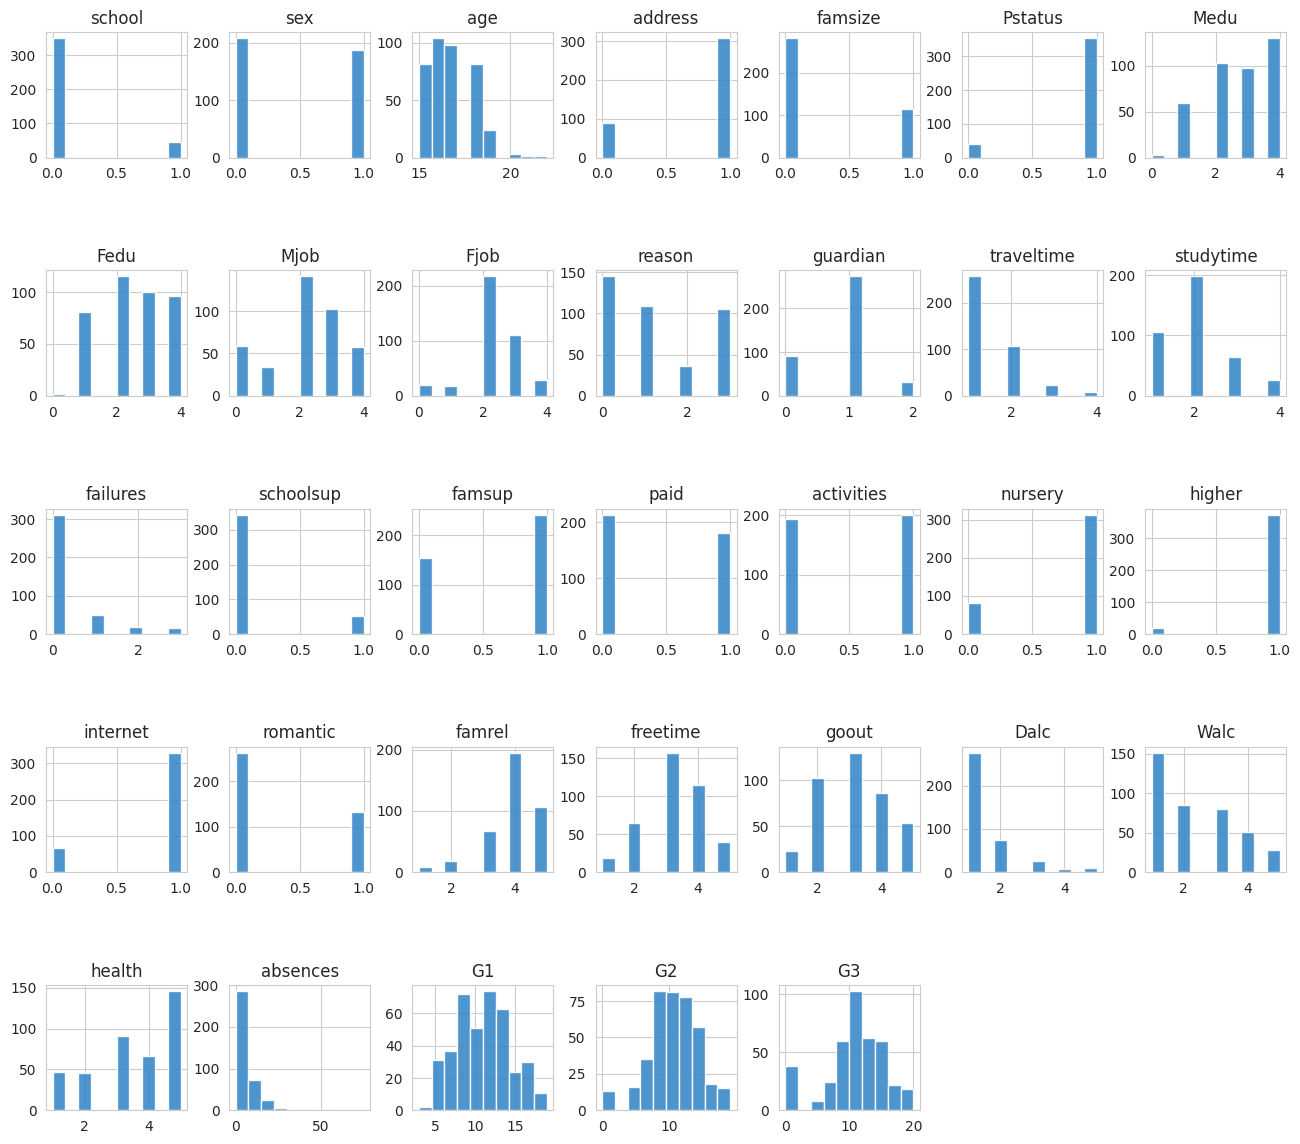

In [8]:
#plot the histogram of each variable in the dataframe
dataframe_raw.hist(grid=True, figsize=(16,14), layout=(5,7), color='#3B88C8', alpha=0.9)
plt.subplots_adjust(hspace=0.9)
#plt.savefig("features_hist.png")
#files.download("features_hist.png") 
plt.show()

In [9]:
#percentage of the outliers int the target variable
len(dataframe_raw[dataframe_raw['G3'] == 0])/395

0.09620253164556962

In [10]:
#counting the total number of outliers
outliers = dataframe_raw[dataframe_raw > dataframe_raw.mean() + 3 * dataframe_raw.std()]
outliers = outliers.fillna(0)
outliers[outliers > 0] = 1
outliers.values.sum()

41.0

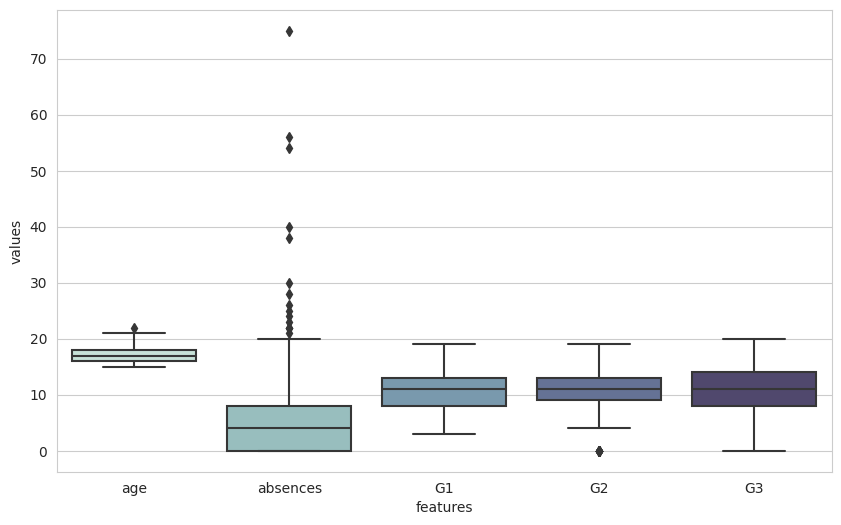

In [11]:
plt.figure(figsize=(10,6))
#plot the boxplots only for the features for which it is meangful to do that
ax = sns.boxplot(data=dataframe_raw[['age', 'absences', 'G1','G2','G3']], palette=sns.color_palette("ch:start=.5,rot=-.5"))
ax.set_ylabel('values')
ax.set_xlabel('features')
#plt.savefig("box_plot.png")
#files.download("box_plot.png") 
plt.show()

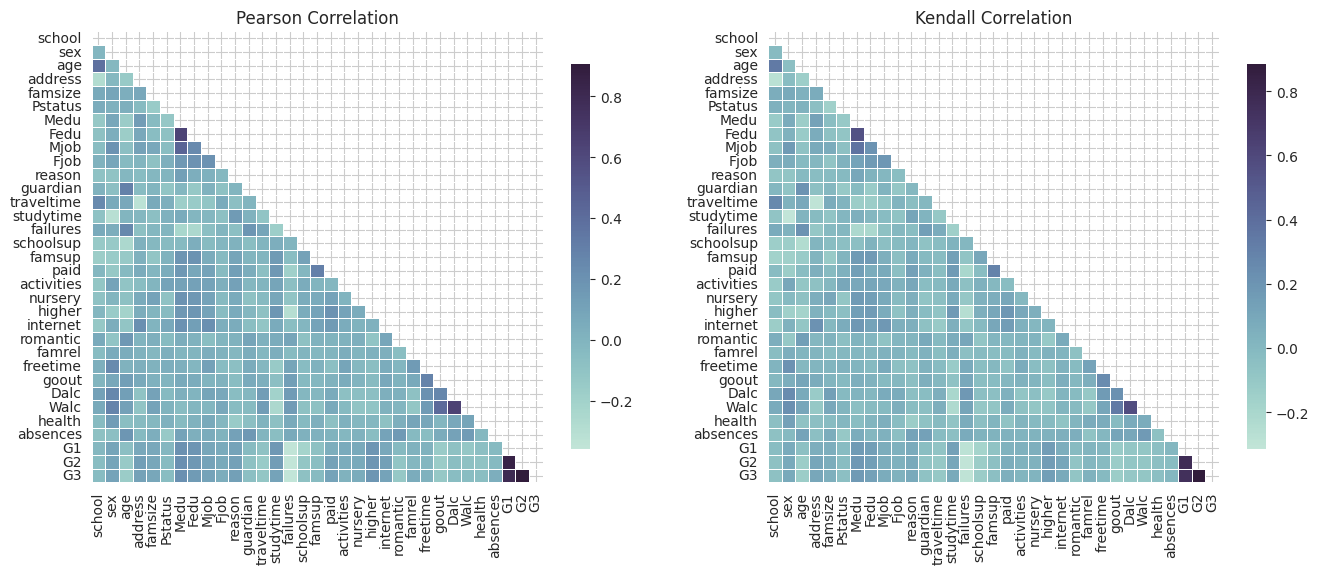

In [12]:
#computing the linear and non linear correlations
corr_pearson = dataframe_raw.corr(method='pearson')
corr_kendall = dataframe_raw.corr(method='kendall')

fig, axs = plt.subplots(1, 2, figsize=(16, 10), sharex=True)

mask = np.triu(np.ones_like(corr_pearson, dtype=bool))
cmap = sns.color_palette("ch:start=.5,rot=-.5", as_cmap=True)

#plotting the Pearson correlation matrix
sns.heatmap(corr_pearson, ax=axs[0], mask=mask, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            xticklabels=True, yticklabels=True)
axs[0].set_title("Pearson Correlation")

#plotting the Kendall correlation matrix
sns.heatmap(corr_kendall, ax=axs[1], mask=mask, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            xticklabels=True, yticklabels=True)
axs[1].set_title("Kendall Correlation")
#plt.savefig("correlations.png")
#files.download("correlations.png") 
plt.show()

Features with Nans values:
Medu
Fedu
famrel
Dalc
absences
     school  sex  age  address  famsize  Pstatus  Medu  Fedu  Mjob  Fjob  ...  \
40        0    0   16        1        1        1   2.0   2.0     2     2  ...   
76        0    1   15        1        0        1   NaN   0.0     4     2  ...   
159       0    1   16        1        0        1   NaN   3.0     2     3  ...   
192       0    1   17        1        0        1   1.0   2.0     0     3  ...   
255       0    1   17        1        1        1   1.0   NaN     1     2  ...   
61        1    0   18        0        1        0   1.0   4.0     0     2  ...   

     famrel  freetime  goout  Dalc  Walc  health  absences  G1  G2  G3  
40      NaN         3      3   1.0     2       3      25.0   7  10  11  
76      3.0         4      3   1.0     1       1       8.0  11  11  10  
159     4.0         5      5   4.0     4       5       4.0  10  12  12  
192     4.0         4      4   NaN     5       5      12.0   7   8   8  
255     4

  0%|          | 0/5 [00:00<?, ?it/s]

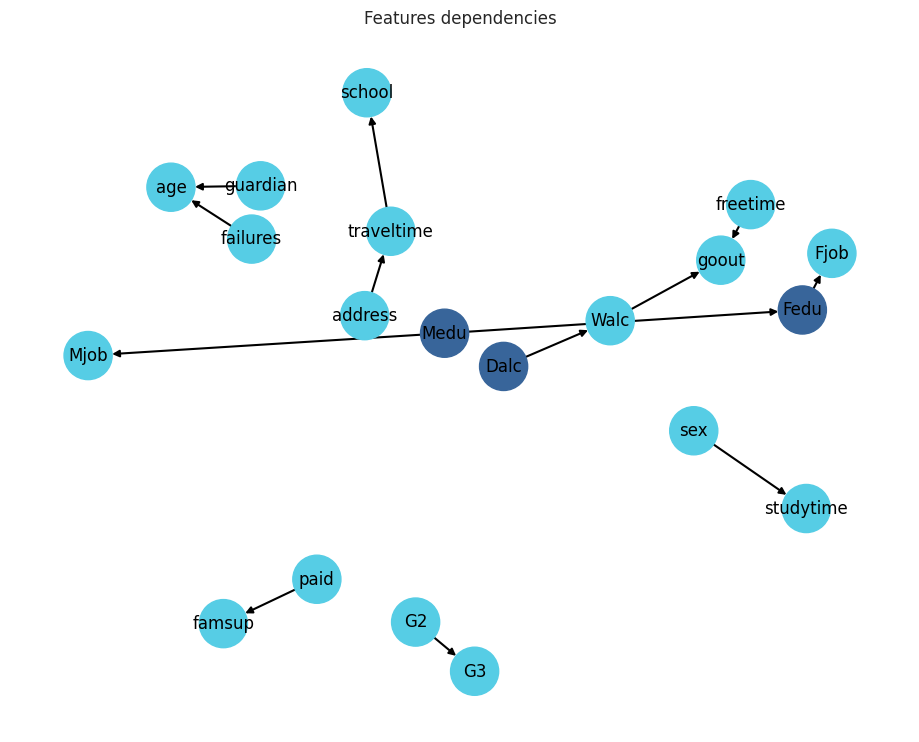

In [13]:
#here we use the pmg method to check the dependency of the variables w.r.t each other
#this will help use in generate more accurate synthetic data to fill the nans in the
#dataframe
columns_with_NaN = dataframe_raw.columns[dataframe_raw.isna().any()].tolist()
print("Features with Nans values:")
for column in columns_with_NaN:
    print(column)

#creating a boolean mask of rows with NaN values in the selected columns
row_mask = dataframe_raw[columns_with_NaN].isna().any(axis=1)

#selecting the rows with NaN values in the selected columns
rows_with_NaN = dataframe_raw[row_mask]
print(rows_with_NaN)

#creating an instance of the constrained-based estimator
#documentation at https://pgmpy.org/structure_estimator/pc.html
pc = PC(dataframe_raw)
graph_structure = pc.estimate(return_type='dag')

#creating a new BayesianModel object from the learned graph skeleton
model = BayesianModel(graph_structure.edges())

nodes_missing_values_feats = columns_with_NaN

#creating a directed graph and adding the computed edges to it
G = nx.DiGraph()
G.add_edges_from(model.edges())

#generating a layout using the Fruchterman-Reingold algorithm
pos = nx.fruchterman_reingold_layout(G, k=0.35, seed=123)

#defining the color for the nodes and edges
color_map = []
for node in G.nodes():
    if node in nodes_missing_values_feats:
        color_map.append('#38659a')
    else:
        color_map.append('#56CDE5')

edge_color = 'black'
edge_width = 1.5
edge_style = 'solid'

#plot the graph with the topological order and adjusted visuals, unluckly we didn't
#menage to find a way to have always the same visual output, so the graph nodes will
#be in a different position each time
plt.figure(figsize=(9,7))
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=1200, node_shape='o', edge_color=edge_color, width=edge_width, style=edge_style)
plt.title('Features dependencies')
plt.show()
#the graph doesn't show variables without dependencies

In [14]:
#function to sample dalc variable conditioned by walc
def sample_Dalc_given(walc, df):
    df = df.dropna()
    #get average for prior on the parameter
    avgW = df['Walc'].mean()
    #filter coincidence with observed walc feature
    subset = dataframe_raw.loc[dataframe_raw['Walc'] == walc]
    #computing paramters of the posterior
    sumW = subset['Walc'].sum()
    numW = subset.shape[0]
    alpha = 1 + sumW
    beta = numW + 1/avgW
    #sampling from the posterior gamma distribution
    gamma_sample = stats.gamma.rvs(a=alpha, scale=1/beta)
    #sampling from a poisson distribution with lambda = the gamma sample
    poisson_sample = stats.poisson.rvs(mu=gamma_sample)
    return poisson_sample

#function to sample the absence variable (not conditioned)
def sample_Absence(df):
    df = df.dropna()
    #computing again paramters of the posterior
    sumA = df['absences'].sum()
    numA = df.shape[0]
    alpha = 3 + sumA
    beta = 0.3 + numA
    #sampling from the posterior gamma distribution
    gamma_sample = stats.gamma.rvs(a=alpha, scale=1/beta)
    #sampling from a poisson distribution with lambda = the gamma sample
    poisson_sample = stats.poisson.rvs(mu=gamma_sample)
    return poisson_sample

#function to sample the famrel variable (not conditioned)
def sample_Famrel(df):
    df = df.dropna()
    #paramters of the posterior dirichlet
    numF = df.shape[0]
    #number of occurences of each possible result
    occ_1 = (df['famrel'] == 1.0).sum()
    occ_2 = (df['famrel'] == 2.0).sum()
    occ_3 = (df['famrel'] == 3.0).sum()
    occ_4 = (df['famrel'] == 4.0).sum()
    occ_5 = (df['famrel'] == 5.0).sum()
    # posterior params considering an ignorant prior on whole dataset
    orig = numF / 5
    alpha = [orig + occ_1, 
             orig + occ_2, 
             orig + occ_3, 
             orig + occ_4, 
             orig + occ_5]
    #sampling from the Dirichlet distribution
    dirichlet_sample = np.random.dirichlet(alpha)
    #sampling from the multinomial distribution
    multinomial_sample = np.random.multinomial(1, dirichlet_sample)
    multinomial_value = np.where(multinomial_sample == 1)[0][0]
    return multinomial_value

#function to sample medu variable conditioned by fedu and mjob
def sample_Medu_given(fedu, mjob, df):
    filtered_data = df[(df['Fedu'] == fedu) & (df['Mjob'] == mjob)]
    filtered_data = filtered_data.dropna()
    #number of occurences of each possible result
    occ_0 = (filtered_data['Medu'] == 0.0).sum()
    occ_1 = (filtered_data['Medu'] == 1.0).sum()
    occ_2 = (filtered_data['Medu'] == 2.0).sum()
    occ_3 = (filtered_data['Medu'] == 3.0).sum()
    occ_4 = (filtered_data['Medu'] == 4.0).sum()
    #posterior params considering uniform prior
    params = [1 + occ_0, 1 + occ_1, 1 + occ_2, 1 + occ_3, 1 + occ_4]
    #sampling from the Dirichlet distribution
    dirichlet_sample = np.random.dirichlet(params)
    #sampling from the multinomial distribution
    sample_medu = np.random.multinomial(1, dirichlet_sample)
    return np.where(sample_medu == 1)[0][0]

#function to sample fedu variable conditioned by medu and mjob
def sample_Fedu_given(medu, fjob, df):
    filtered_data = df[(df['Medu'] == 1.0) & (df['Fjob'] == fjob)]
    filtered_data = filtered_data.dropna()
    #number of occurences of each possible result
    occ_0 = (filtered_data['Fedu'] == 0.0).sum()
    occ_1 = (filtered_data['Fedu'] == 1.0).sum()
    occ_2 = (filtered_data['Fedu'] == 2.0).sum()
    occ_3 = (filtered_data['Fedu'] == 3.0).sum()
    occ_4 = (filtered_data['Fedu'] == 4.0).sum()
    #posterior params considering uniform prior
    params = [1 + occ_0, 1 + occ_1, 1 + occ_2, 1 + occ_3, 1 + occ_4]
    #sampling from the Dirichlet distribution
    dirichlet_sample = np.random.dirichlet(params)
    #sampling from the multinomial distribution
    sample_medu = np.random.multinomial(1, dirichlet_sample)
    return np.where(sample_medu == 1)[0][0]


dataframe_raw = dataframe_raw.reset_index(drop=True)

#filling in missing values for the Dalc feature column
dataframe_raw.loc[dataframe_raw['Dalc'].isnull(), 'Dalc'] = dataframe_raw.loc[dataframe_raw['Dalc'].isnull()].apply(lambda row: sample_Dalc_given(row['Walc'], dataframe_raw), axis=1)
#filling in missing values for the Absence feature column
dataframe_raw.loc[dataframe_raw['absences'].isnull(), 'absences'] = dataframe_raw.apply(lambda row: sample_Absence(dataframe_raw) if pd.isnull(row['absences']) else row['absences'], axis=1)
#filling in missing values for the famrel feature column
dataframe_raw.loc[dataframe_raw['famrel'].isnull(), 'famrel'] = dataframe_raw.apply(lambda row: sample_Famrel(dataframe_raw) if pd.isnull(row['famrel']) else row['famrel'], axis=1)
#filling in missing values for the Medu feature column
dataframe_raw.loc[dataframe_raw['Medu'].isnull(), 'Medu'] = dataframe_raw.loc[dataframe_raw['Medu'].isnull()].apply(lambda row: sample_Medu_given(row['Fedu'], row['Mjob'], dataframe_raw), axis=1)
#filling in missing values for the Fedu feature column
dataframe_raw.loc[dataframe_raw['Fedu'].isnull(), 'Fedu'] = dataframe_raw.loc[dataframe_raw['Fedu'].isnull()].apply(lambda row: sample_Fedu_given(row['Medu'], row['Fjob'], dataframe_raw), axis=1)

#creating a boolean mask of rows with NaN values in the selected columns
row_mask = dataframe_raw[columns_with_NaN].isna().any(axis=1)
#selecting the rows with NaN values in the selected columns
rows_with_NaN = dataframe_raw[row_mask]

dataframe_final = dataframe_raw
#print the rows that had the nans values in them
dataframe_final[row_mask]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3


In [15]:
#creating a dataframe to save the performance of all the models we will use
performance = pd.DataFrame(columns= ['model', 'accuracy', 'precision', 'recall', 'f1-score'])

In [16]:
#we noticed that using G2 as exact predictor of G3, the F1 score is around 40/50% depending 
#on the portion taken,here we show it above the whole dataset, this may be an hinsight
#about the relation between G2 and G3
f1_score(dataframe_final['G2'], dataframe_final['G3'], average='weighted')

0.4838075902343597

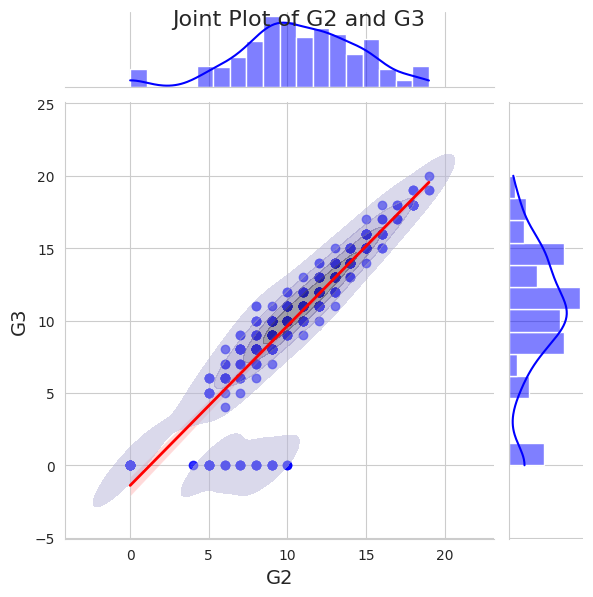

In [17]:
#creating the jointplot with custom settings to shoe G3 in relation to G2
g = sns.jointplot(data=dataframe_final, x='G2', y='G3', kind='reg', color="b", 
                  line_kws={'linewidth': 2, 'color': 'red'})

#adding a Gaussian distribution plot to see the density
feature = dataframe_final['G2']
label = dataframe_final['G3']
x_mean, x_std = np.mean(feature), np.std(feature)
y_mean, y_std = np.mean(label), np.std(label)
sns.kdeplot(x=feature, y=label, levels=5, color='#275785', alpha=0.5, thresh=0.05, shade=True, ax=g.ax_joint, cmap="Purples_d")

g.set_axis_labels('G2', 'G3', fontsize=14)
g.fig.suptitle('Joint Plot of G2 and G3', fontsize=16)
#plt.savefig("g2g3.png")
#files.download("g2g3.png") 
plt.show()

In [18]:
#dividing features and label
#we do not use the test set given in the beginning on purpose,
#since the best way to evaluate a model is perform a stratified (since it is not balanced)
#kfold cross validation among the dataset
features = dataframe_final.drop("G3", axis=1)
labels = dataframe_final["G3"]

In [19]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=5)

In [20]:
#due to the correlation shape between G2 and G3 we first try to fit some 
#regression models rounding the predition in order to be able to apply
#the same metrics we will then use for the classification and for having a
#better comparison
reg = ElasticNet(alpha=0.3, l1_ratio=0.7, random_state=1)
#we use a stratified Kfold to perform kfold validation preserving the distribution
#of the data, this is the standard approach when the target class is not balanced
#creating the usual empty list to store the F1 scores for each fold and classifier
y_pred_linreg = []
y_true_linreg = []
r2_scores = []
mse_scores = []
#iterating over each classifier and perform K-fold cross-validation 
for train_index, test_index in skf.split(features, labels):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
    reg.fit(X_train, y_train)
    temp_pred = reg.predict(X_test)
    #we round the prediction to the closest int to then compute the metrics
    y_pred_linreg.extend(temp_pred.astype(int))
    y_true_linreg.extend(y_test.astype(int))
    r2_scores.append(r2_score(y_test, temp_pred))
    mse_scores.append(mean_squared_error(y_test.astype(int), temp_pred.astype(int)))
    #we save the results in this dataframe to then comare them with the classification models
    performance = performance.append({'model': 'LinReg',
                    'accuracy': accuracy_score(y_test.astype(int), temp_pred.astype(int)),
                    'precision':precision_score(y_test.astype(int), temp_pred.astype(int), average='weighted'),
                    'recall': recall_score(y_test.astype(int), temp_pred.astype(int), average='weighted'),
                    'f1-score': f1_score(y_test.astype(int), temp_pred.astype(int), average='weighted')}, ignore_index=True)

print(f"Mean r2 score: {sum(r2_scores) / len(r2_scores):.2f}")
print(f"Mean mse score: {sum(mse_scores) / len(mse_scores):.2f}")
print(f"Mean precision: {performance['precision'].loc[(performance['model'] == 'LinReg')].values.mean():.2f}")
print(f"Mean recall: {performance['recall'].loc[(performance['model'] == 'LinReg')].values.mean():.2f}")
print(f"Mean f1-score: {performance['f1-score'].loc[(performance['model'] == 'LinReg')].values.mean():.2f}")



Mean r2 score: 0.82
Mean mse score: 4.02
Mean precision: 0.34
Mean recall: 0.27
Mean f1-score: 0.27


In [21]:
#creating a random forest regressor object
rf = RandomForestRegressor(n_estimators=100, random_state=1)

#the structure of this code is the same as before, the only thing that
#is changed is the used model
y_pred_rfr = []
y_true_rfr = []
r2_scores = []
mse_scores = []
for train_index, test_index in skf.split(features, labels):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
    rf.fit(X_train, y_train)
    temp_pred = rf.predict(X_test)
    y_pred_rfr.extend(temp_pred.astype(int))
    y_true_rfr.extend(y_test)
    r2_scores.append(r2_score(y_test, temp_pred))
    mse_scores.append(mean_squared_error(y_test.astype(int), temp_pred.astype(int)))
    performance = performance.append({'model': 'RfReg',
                    'accuracy': accuracy_score(y_test.astype(int), temp_pred.astype(int)),
                    'precision':precision_score(y_test.astype(int), temp_pred.astype(int), average='weighted'),
                    'recall': recall_score(y_test.astype(int), temp_pred.astype(int), average='weighted'),
                    'f1-score': f1_score(y_test.astype(int), temp_pred.astype(int), average='weighted')}, ignore_index=True)


print(f"Mean R2 score: {sum(r2_scores) / len(r2_scores):.2f}")
print(f"Mean MSE score: {sum(mse_scores) / len(mse_scores):.2f}")
print(f"Mean precision non-pca: {performance['precision'].loc[(performance['model'] == 'RfReg')].values.mean():.2f}")
print(f"Mean recall non-pca: {performance['recall'].loc[(performance['model'] == 'RfReg')].values.mean():.2f}")
print(f"Mean f1-score non-pca: {performance['f1-score'].loc[(performance['model'] == 'RfReg')].values.mean():.2f}")

Mean R2 score: 0.89
Mean MSE score: 2.71
Mean precision non-pca: 0.46
Mean recall non-pca: 0.42
Mean f1-score non-pca: 0.41


In [22]:
from sklearn.neural_network import MLPRegressor

#creating a Multi-layer Perceptron regressor
mlp = MLPRegressor(hidden_layer_sizes=(200, 20), activation='relu', solver='adam', max_iter=1000, random_state=5,
                   early_stopping=True, validation_fraction=0.1, tol=1e-4)

#the structure of this code is the same as before, the only thing that
#is changed is the used model
y_pred_mlp = []
y_true_mlp = []
r2_scores = []
mse_scores = []
for train_index, test_index in skf.split(features, labels):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
    mlp.fit(X_train, y_train)
    temp_pred = mlp.predict(X_test)
    y_pred_mlp.extend(temp_pred.astype(int))
    y_true_mlp.extend(y_test)
    r2_scores.append(r2_score(y_test, temp_pred))
    mse_scores.append(mean_squared_error(y_test.astype(int), temp_pred.astype(int)))
    performance = performance.append({'model': 'MLPReg',
                    'accuracy': accuracy_score(y_test.astype(int), temp_pred.astype(int)),
                    'precision':precision_score(y_test.astype(int), temp_pred.astype(int), average='weighted'),
                    'recall': recall_score(y_test.astype(int), temp_pred.astype(int), average='weighted'),
                    'f1-score': f1_score(y_test.astype(int), temp_pred.astype(int), average='weighted')}, ignore_index=True)


print(f"Mean R2 score: {sum(r2_scores) / len(r2_scores):.2f}")
print(f"Mean MSE score: {sum(mse_scores) / len(mse_scores):.2f}")
print(f"Mean precision non-pca: {performance['precision'].loc[(performance['model'] == 'MLPReg')].values.mean():.2f}")
print(f"Mean recall non-pca: {performance['recall'].loc[(performance['model'] == 'MLPReg')].values.mean():.2f}")
print(f"Mean f1-score non-pca: {performance['f1-score'].loc[(performance['model'] == 'MLPReg')].values.mean():.2f}")


Mean R2 score: 0.86
Mean MSE score: 3.30
Mean precision non-pca: 0.39
Mean recall non-pca: 0.33
Mean f1-score non-pca: 0.33


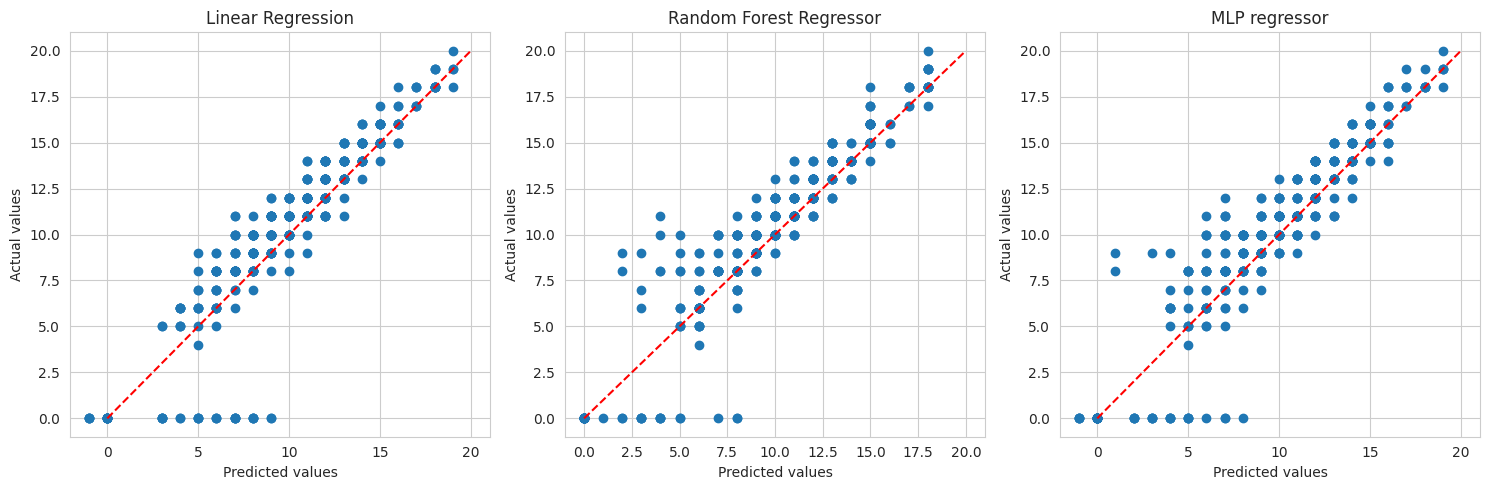

In [23]:
#plotting the predicted vs actual values and a 'perfect'
#regression as visual reference (means that classify correctly each)
#datapoint would result in line as the red one

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

#linear regression subplot
axes[0].scatter(y_pred_linreg, y_true_linreg)
axes[0].plot([labels.min(), labels.max()], [labels.min(), labels.max()], '--', color='red')
axes[0].set_ylabel('Actual values')
axes[0].set_xlabel('Predicted values')
axes[0].set_title('Linear Regression')

#rf regressor subplot
axes[1].scatter(y_pred_rfr, y_true_rfr)
axes[1].plot([labels.min(), labels.max()], [labels.min(), labels.max()], '--', color='red')
axes[1].set_ylabel('Actual values')
axes[1].set_xlabel('Predicted values')
axes[1].set_title('Random Forest Regressor')

#mlp regressor subplot
axes[2].scatter(y_pred_mlp, y_true_mlp)
axes[2].plot([labels.min(), labels.max()], [labels.min(), labels.max()], '--', color='red')
axes[2].set_ylabel('Actual values')
axes[2].set_xlabel('Predicted values')
axes[2].set_title('MLP regressor')

plt.tight_layout()
#plt.savefig("regressions.png")
#files.download("regressions.png")
plt.show()

In [24]:
#we have tried also using only G2 as features to reduce the
#dimensionality, but that resulted in worst performance, 
#to avoid a super long notebook we have deleted it

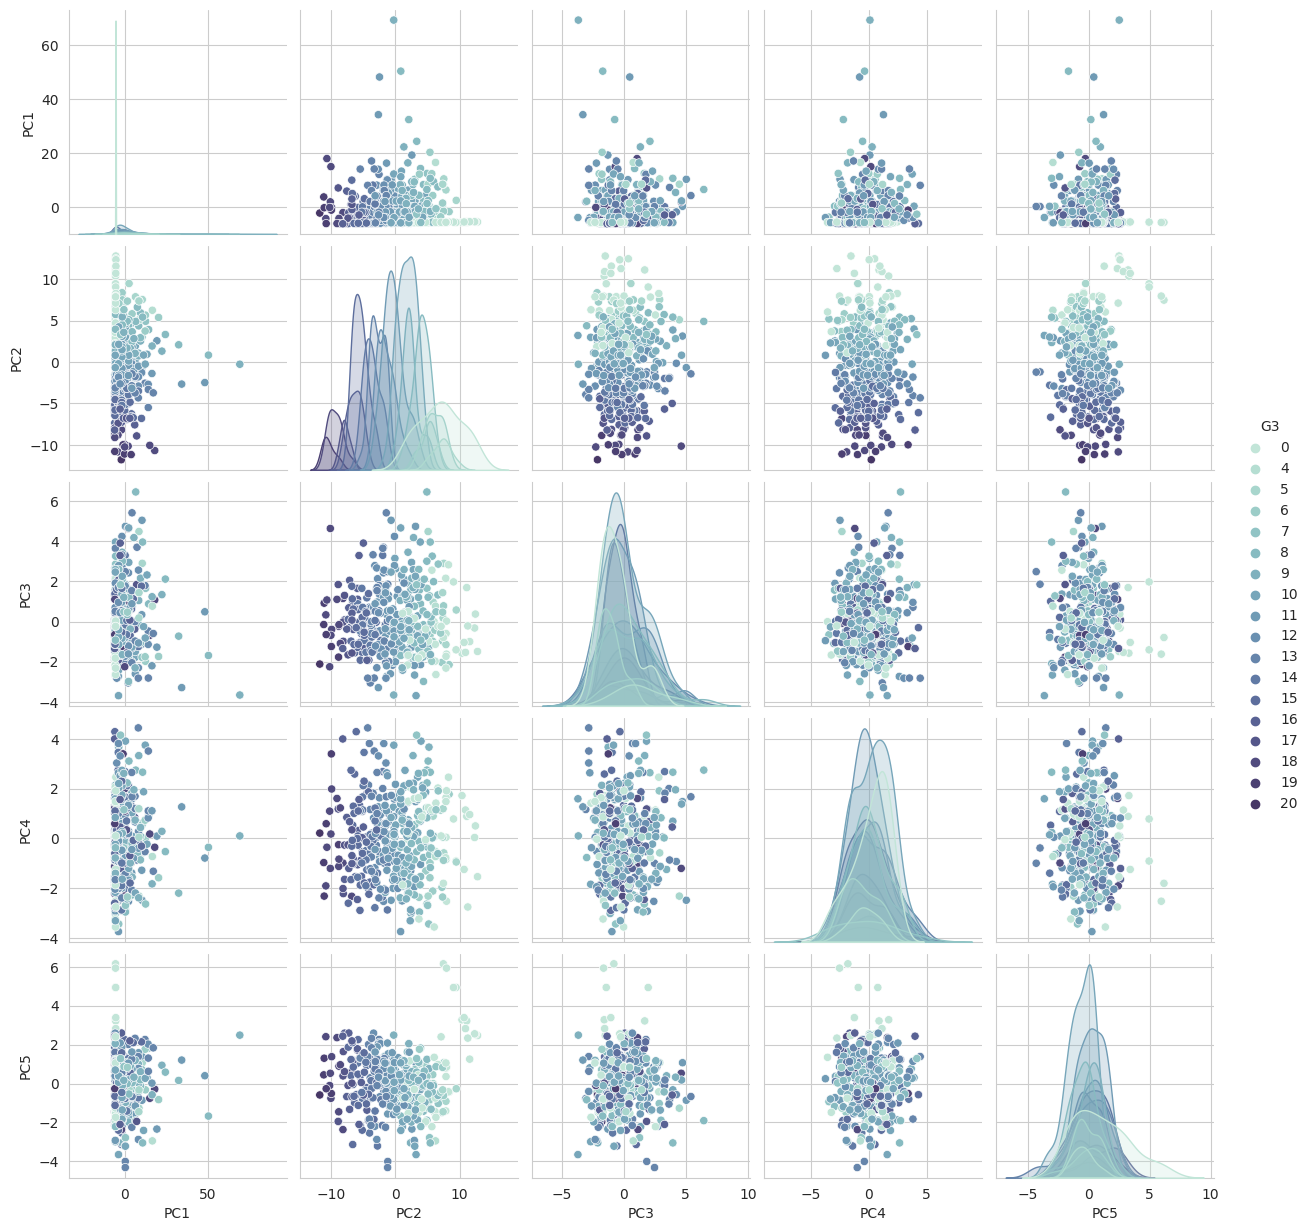

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,G3
0,0.481611,7.315188,-0.960582,-0.805776,-0.795478,0.470622,-0.901406,1.335066,0.884183,3.215020,1.348422,-0.436945,6
1,-1.598276,8.354530,-2.141312,1.778162,-0.427639,-1.045633,-0.349982,0.988840,-0.850771,0.986968,0.678676,-0.776644,6


In [25]:
features = dataframe_final.drop('G3', axis=1)
labels = dataframe_final['G3']

#we create a pca instance specifing the amount of variance we want to keep
pca = PCA(n_components=0.95)
#standardizing the data results in a degeneration of the eigenvectors
#of the pca since we have a lot of binary and numeric features, leading to 
#worst result. Not standardizing, event if not theoretically correct
#leads to the best results.
#pca = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=0.95))])

# Fit and transform the data to the first three principal components

features_pca = pca.fit_transform(features)
#creating a temporary dict to transform into a dataframe
temp_dict = {'PC'+str(i+1): features_pca[:,i] for i in range(np.shape(features_pca)[1])}
temp_dict['G3'] = labels
df_pca = pd.DataFrame(temp_dict)

#plotting a pairplot of the first five principal components
to_plot = pd.DataFrame({'PC1': features_pca[:, 0], 'PC2': features_pca[:, 1], 'PC3': features_pca[:, 2],
                        'PC4': features_pca[:, 3], 'PC5': features_pca[:, 4], 'G3': labels})
sns.pairplot(to_plot, hue='G3', palette=sns.color_palette("ch:start=.5,rot=-.5", 21))
plt.show()
df_pca.head(2)

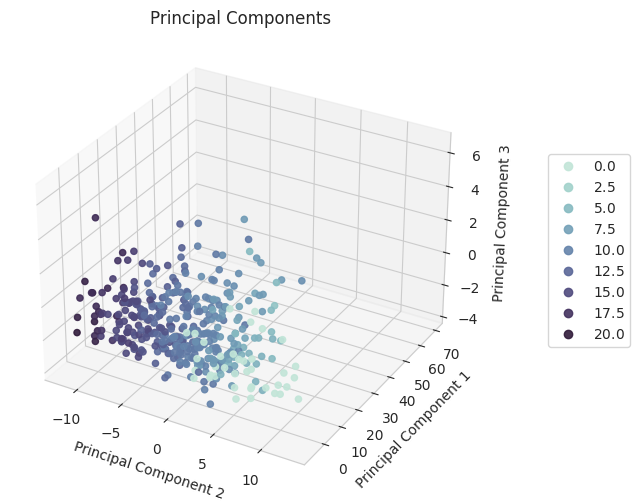

In [26]:
plt.figure(figsize=(8,6))
axes = plt.axes(projection='3d')

#creating a 3d scatterplot to visualize in 3d the first three principal components, 
#from the plot we can already see a cluster pattern of the data, suitable for a 
#classification approach so we decided to try some classification models as well
#comparing them with the three regression models used
threeD_plot = axes.scatter3D(df_pca['PC2'], df_pca['PC1'], df_pca['PC3'], c=df_pca['G3'], 
                    cmap=sns.color_palette("ch:start=.5,rot=-.5", as_cmap=True), alpha=.9)

axes.set_xlabel('Principal Component 2')
axes.set_ylabel('Principal Component 1')
axes.set_zlabel('Principal Component 3')
axes.set_title('Principal Components')
plt.legend(*threeD_plot.legend_elements(), bbox_to_anchor=(1.15, .75), loc=2)
#plt.savefig("pca.png", bbox_inches="tight")
#files.download("pca.png") 
plt.show()

In [27]:
#dividing features and labels 
features_pca = df_pca.drop("G3", axis=1)
labels_pca = df_pca["G3"]

Mean precision pca: 0.39
Mean recall pca: 0.44
Mean f1-score pca: 0.40
--------------------------------------------------------------
Mean precision non-pca: 0.37
Mean recall non-pca: 0.41
Mean f1-score non-pca: 0.37
--------------------------------------------------------------


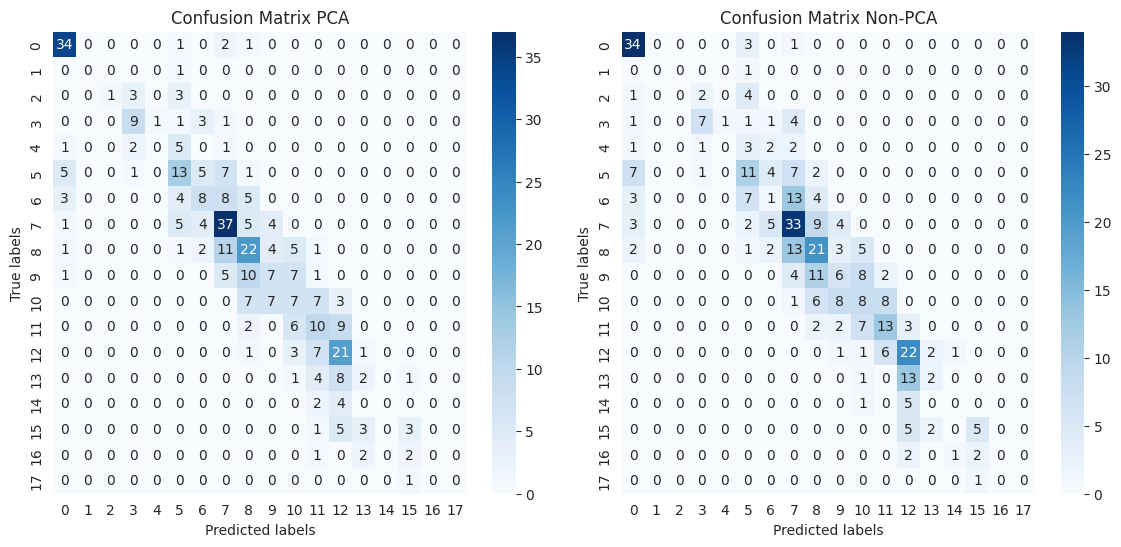

In [28]:
#creating a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=5)

#we again use for each classification model a stratified kfold cross validation
#as did for the regression
y_pred = []
y_true = []
for train_index, test_index in skf.split(features_pca, labels_pca):
    X_train, X_test = features_pca.iloc[train_index], features_pca.iloc[test_index]
    y_train, y_test = labels_pca.iloc[train_index], labels_pca.iloc[test_index]
    rf.fit(X_train, y_train)
    t = rf.predict(X_test)
    y_pred.extend(t)
    y_true.extend(y_test)
    #saving the performance in the same dataframe as for the regressions
    #to then compare every model's performance
    performance = performance.append({'model': 'RF - PCA',
                    'accuracy': accuracy_score(y_test, t),
                    'precision':precision_score(y_test, t, average='weighted'),
                    'recall': recall_score(y_test, t, average='weighted'),
                    'f1-score': f1_score(y_test, t, average='weighted')}, ignore_index=True)

print(f"Mean precision pca: {performance['precision'].loc[(performance['model'] == 'RF - PCA')].values.mean():.2f}")
print(f"Mean recall pca: {performance['recall'].loc[(performance['model'] == 'RF - PCA')].values.mean():.2f}")
print(f"Mean f1-score pca: {performance['f1-score'].loc[(performance['model'] == 'RF - PCA')].values.mean():.2f}")
print('--------------------------------------------------------------')

#calculating the confusion matrix
cmpca = confusion_matrix(y_true, y_pred)

#createing a new instance of Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=5)

#this script is the same as above but using the non pca dataframe instead
#to compare the performance and check which one is better
y_pred = []
y_true = []
for train_index, test_index in skf.split(features, labels):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
    rf.fit(X_train, y_train)
    t = rf.predict(X_test)
    y_pred.extend(t)
    y_true.extend(y_test)
    performance = performance.append({'model': 'RF',
                    'accuracy': accuracy_score(y_test, t),
                    'precision':precision_score(y_test, t, average='weighted'),
                    'recall': recall_score(y_test, t, average='weighted'),
                    'f1-score': f1_score(y_test, t, average='weighted')}, ignore_index=True)
    
print(f"Mean precision non-pca: {performance['precision'].loc[(performance['model'] == 'RF')].values.mean():.2f}")
print(f"Mean recall non-pca: {performance['recall'].loc[(performance['model'] == 'RF')].values.mean():.2f}")
print(f"Mean f1-score non-pca: {performance['f1-score'].loc[(performance['model'] == 'RF')].values.mean():.2f}")
print('--------------------------------------------------------------')

#calculating the confusion matrix also for this model
cmall = confusion_matrix(y_true, y_pred)

#creating the figure and subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

#plotting the first heatmap
sns.heatmap(cmpca, annot=True, cmap=sns.color_palette("Blues", as_cmap=True), fmt="d", ax=ax1)
ax1.set_xlabel("Predicted labels")
ax1.set_ylabel("True labels")
ax1.set_title("Confusion Matrix PCA")

#plotting the second heatmap
sns.heatmap(cmall, annot=True, cmap=sns.color_palette("Blues", as_cmap=True), fmt="d", ax=ax2)
ax2.set_xlabel("Predicted labels")
ax2.set_ylabel("True labels")
ax2.set_title("Confusion Matrix Non-PCA")

plt.subplots_adjust(wspace=0.1)
plt.show()

Mean precision pca: 0.20
Mean recall pca: 0.25
Mean f1-score pca: 0.20
--------------------------------------------------------------
Mean precision non-pca: 0.19
Mean recall non-pca: 0.24
Mean f1-score non-pca: 0.19
--------------------------------------------------------------


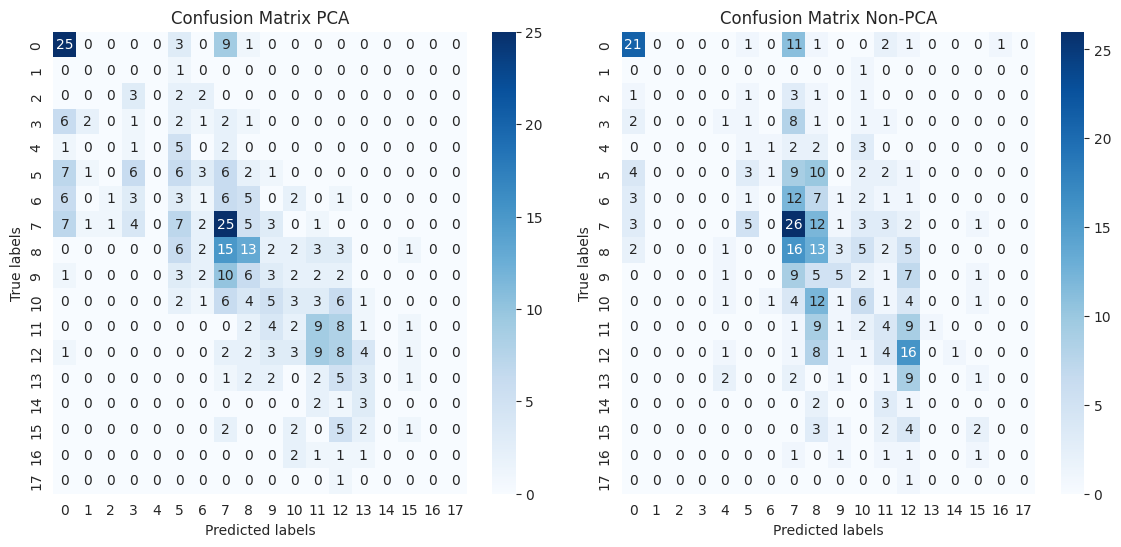

In [29]:
#creating a MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', max_iter=1000, random_state=5,
                   early_stopping=True, validation_fraction=0.1, tol=1e-4)

#again the code is the same as before, the only thing changed is the model
#used for the classification

y_pred = []
y_true = []
for train_index, test_index in skf.split(features_pca, labels_pca):
    X_train, X_test = features_pca.iloc[train_index], features_pca.iloc[test_index]
    y_train, y_test = labels_pca.iloc[train_index], labels_pca.iloc[test_index]
    mlp.fit(X_train, y_train)
    t = mlp.predict(X_test)
    y_pred.extend(t)
    y_true.extend(y_test)
    performance = performance.append({'model': 'MLP - PCA',
                    'accuracy': accuracy_score(y_test, t),
                    'precision':precision_score(y_test, t, average='weighted'),
                    'recall': recall_score(y_test, t, average='weighted'),
                    'f1-score': f1_score(y_test, t, average='weighted')}, ignore_index=True)

print(f"Mean precision pca: {performance['precision'].loc[(performance['model'] == 'MLP - PCA')].values.mean():.2f}")
print(f"Mean recall pca: {performance['recall'].loc[(performance['model'] == 'MLP - PCA')].values.mean():.2f}")
print(f"Mean f1-score pca: {performance['f1-score'].loc[(performance['model'] == 'MLP - PCA')].values.mean():.2f}")
print('--------------------------------------------------------------')

cmpca = confusion_matrix(y_true, y_pred)

mlp = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', max_iter=1000, random_state=5,
                   early_stopping=True, validation_fraction=0.1, tol=1e-4)

y_pred = []
y_true = []
for train_index, test_index in skf.split(features, labels):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
    mlp.fit(X_train, y_train)
    t = mlp.predict(X_test)
    y_pred.extend(t)
    y_true.extend(y_test)
    performance = performance.append({'model': 'MLP',
                    'accuracy': accuracy_score(y_test, t),
                    'precision':precision_score(y_test, t, average='weighted'),
                    'recall': recall_score(y_test, t, average='weighted'),
                    'f1-score': f1_score(y_test, t, average='weighted')}, ignore_index=True)

print(f"Mean precision non-pca: {performance['precision'].loc[(performance['model'] == 'MLP')].values.mean():.2f}")
print(f"Mean recall non-pca: {performance['recall'].loc[(performance['model'] == 'MLP')].values.mean():.2f}")
print(f"Mean f1-score non-pca: {performance['f1-score'].loc[(performance['model'] == 'MLP')].values.mean():.2f}")
print('--------------------------------------------------------------')

cmall = confusion_matrix(y_true, y_pred)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

sns.heatmap(cmpca, annot=True, cmap=sns.color_palette("Blues", as_cmap=True), fmt="d", ax=ax1)
ax1.set_xlabel("Predicted labels")
ax1.set_ylabel("True labels")
ax1.set_title("Confusion Matrix PCA")

sns.heatmap(cmall, annot=True, cmap=sns.color_palette("Blues", as_cmap=True), fmt="d", ax=ax2)
ax2.set_xlabel("Predicted labels")
ax2.set_ylabel("True labels")
ax2.set_title("Confusion Matrix Non-PCA")

plt.subplots_adjust(wspace=0.1)
plt.show()

Mean precision pca: 0.45
Mean recall pca: 0.47
Mean f1-score pca: 0.45
--------------------------------------------------------------
Mean precision non-pca: 0.45
Mean recall non-pca: 0.43
Mean f1-score non-pca: 0.42
--------------------------------------------------------------


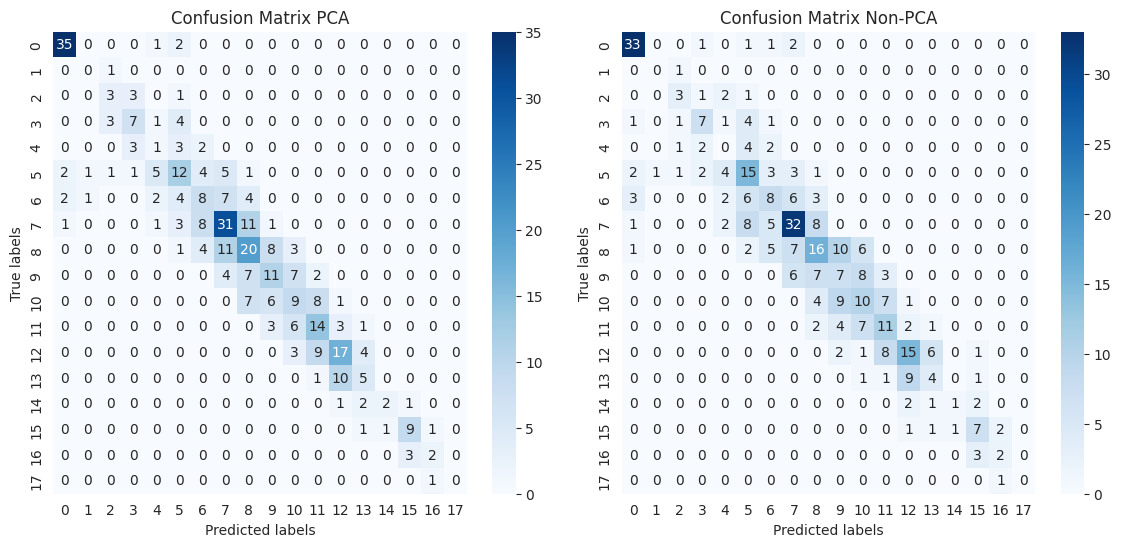

In [30]:
#creating an SVM classifier
svm = SVC(kernel='linear', gamma=1, C=10, random_state=5)

#again the code is the same as before, the only thing changed is the model
#used for the classification

y_pred = []
y_true = []
for train_index, test_index in skf.split(features_pca, labels_pca):
    X_train, X_test = features_pca.iloc[train_index], features_pca.iloc[test_index]
    y_train, y_test = labels_pca.iloc[train_index], labels_pca.iloc[test_index]
    svm.fit(X_train, y_train)
    t = svm.predict(X_test)
    y_pred.extend(t)
    y_true.extend(y_test)
    performance = performance.append({'model': 'SVM - PCA',
                    'accuracy': accuracy_score(y_test, t),
                    'precision':precision_score(y_test, t, average='weighted'),
                    'recall': recall_score(y_test, t, average='weighted'),
                    'f1-score': f1_score(y_test, t, average='weighted')}, ignore_index=True)

print(f"Mean precision pca: {performance['precision'].loc[(performance['model'] == 'SVM - PCA')].values.mean():.2f}")
print(f"Mean recall pca: {performance['recall'].loc[(performance['model'] == 'SVM - PCA')].values.mean():.2f}")
print(f"Mean f1-score pca: {performance['f1-score'].loc[(performance['model'] == 'SVM - PCA')].values.mean():.2f}")
print('--------------------------------------------------------------')

cmpca = confusion_matrix(y_true, y_pred)

svm = SVC(kernel='linear', gamma=1, C=10, random_state=5)

y_pred = []
y_true = []
for train_index, test_index in skf.split(features, labels):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
    svm.fit(X_train, y_train)
    t = svm.predict(X_test)
    y_pred.extend(t)
    y_true.extend(y_test)
    performance = performance.append({'model': 'SVM',
                    'accuracy': accuracy_score(y_test, t),
                    'precision':precision_score(y_test, t, average='weighted'),
                    'recall': recall_score(y_test, t, average='weighted'),
                    'f1-score': f1_score(y_test, t, average='weighted')}, ignore_index=True)

print(f"Mean precision non-pca: {performance['precision'].loc[(performance['model'] == 'SVM')].values.mean():.2f}")
print(f"Mean recall non-pca: {performance['recall'].loc[(performance['model'] == 'SVM')].values.mean():.2f}")
print(f"Mean f1-score non-pca: {performance['f1-score'].loc[(performance['model'] == 'SVM')].values.mean():.2f}")
print('--------------------------------------------------------------')

cmall = confusion_matrix(y_true, y_pred)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

sns.heatmap(cmpca, annot=True, cmap=sns.color_palette("Blues", as_cmap=True), fmt="d", ax=ax1)
ax1.set_xlabel("Predicted labels")
ax1.set_ylabel("True labels")
ax1.set_title("Confusion Matrix PCA")

sns.heatmap(cmall, annot=True, cmap=sns.color_palette("Blues", as_cmap=True), fmt="d", ax=ax2)
ax2.set_xlabel("Predicted labels")
ax2.set_ylabel("True labels")
ax2.set_title("Confusion Matrix Non-PCA")

plt.subplots_adjust(wspace=0.1)
plt.show()

In [32]:
#mean performance of each model
performance.groupby('model').mean()

,accuracy,precision,recall,f1-score
model,,,,
LinReg,0.267500,0.340913,0.267500,0.268683
MLP,0.243397,0.188899,0.243397,0.187152
MLP - PCA,0.248910,0.199946,0.248910,0.202279
MLPReg,0.331667,0.386886,0.331667,0.329024
RF,0.412564,0.365110,0.412564,0.370967
RF - PCA,0.440192,0.390970,0.440192,0.399703
RfReg,0.420064,0.457159,0.420064,0.410705
SVM,0.432949,0.446180,0.432949,0.416355
SVM - PCA,0.470897,0.453936,0.470897,0.447524


In [33]:
#standard deviation of the mean performance of each model
performance.groupby('model').std()

,accuracy,precision,recall,f1-score
model,,,,
LinReg,0.118486,0.153753,0.118486,0.113681
MLP,0.098844,0.093784,0.098844,0.091408
MLP - PCA,0.105748,0.122921,0.105748,0.103408
MLPReg,0.080878,0.112061,0.080878,0.090229
RF,0.052072,0.083100,0.052072,0.054766
RF - PCA,0.048955,0.057859,0.048955,0.048570
RfReg,0.066842,0.073446,0.066842,0.067434
SVM,0.057346,0.056701,0.057346,0.045679
SVM - PCA,0.091058,0.075763,0.091058,0.078630


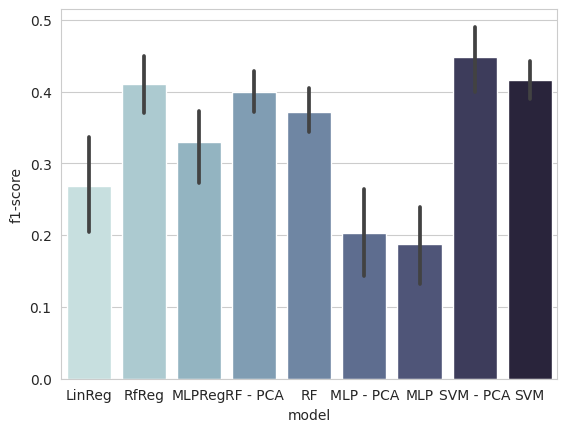

In [34]:
p = sns.barplot(data=performance, x="model", y="f1-score", palette=sns.color_palette("ch:start=.2,rot=-.3", 9))
#plt.savefig("models_f1.png")
#files.download("models_f1.png") 
plt.show()

In [49]:
#THIS TAKES ABOUT 20/30 MINS TO RUN
#svm hyperparameters final tuning
#perform stratified k-fold cross-validation and get the predicted labels and accuracy scores
highest_f1 = 0
parameters = {'kernel':('linear', 'rbf', 'poly'), 
              'C':[0.01, 0.1, 1, 10, 100],
              'gamma':[0.01, 0.1, 1, 10, 100],
              'degree':[0, 1, 2, 3, 4]}

svm = SVC(random_state=11)
#stratifiedKfold is used by default
clf_grid = GridSearchCV(svm, parameters, cv=10, scoring='f1_weighted', n_jobs=-1)
clf_grid.fit(features_pca, labels_pca)
sorted(clf_grid.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_degree',
 'param_gamma',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'split5_test_score',
 'split6_test_score',
 'split7_test_score',
 'split8_test_score',
 'split9_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [50]:
clf_grid.best_params_

{'C': 0.1, 'degree': 1, 'gamma': 10, 'kernel': 'poly'}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

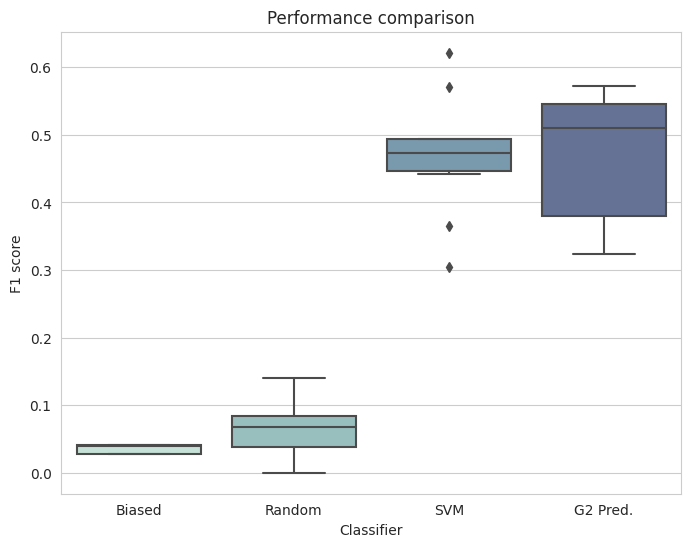

Mean F1-score svm: 0.46953259738836667
Mean F1-score G2: 0.4714558312058312


In [55]:
#now we evaluate the svm classifier using the best hyperparameters found so far
#and we compare it with the baseline classifiers (radom and biased)
biased = DummyClassifier(strategy='most_frequent')
random = DummyClassifier(strategy='uniform', random_state=0)
#we use the svm found before since the refit option in the grid search is set to true
classifiers = [('Biased', biased),
               ('Random', random),
               ('SVM', clf_grid.best_estimator_),
               ('G2 Pred.', None)]

#creating the usual empty list to store the F1 scores for each fold and classifier
f1_scores = []
svm_predictions = []
g2_predictions = []
real_labels = []
#iterating over each classifier and perform K-fold cross-validation as did before for each model
for clf_name, clf in classifiers:
    clf_f1_scores = []
    for train_index, test_index in skf.split(features_pca, labels_pca):
        
        if not clf_name == 'G2 Pred.':
          X_train, X_test = features_pca.iloc[train_index], features_pca.iloc[test_index]
          y_train, y_test = labels_pca.iloc[train_index], labels_pca.iloc[test_index]
          #training the classifier on the train set and predict on the test set
          clf.fit(X_train, y_train)
          y_pred = clf.predict(X_test)
          if clf_name == 'SVM':
            svm_predictions.extend(y_pred)
            real_labels.extend(y_test)
            #calculating the F1 score on the test set
          
          clf_f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        else:
          X_train, X_test = features.iloc[train_index], features.iloc[test_index]
          y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
          #if the classifier is the features G2 we drect consider it as predictor
          g2_predictions.extend(X_test['G2'].tolist())
          clf_f1_scores.append(f1_score(y_test, X_test[['G2']], average='weighted'))

        

    #adding the list of F1 scores for this classifier to the overall list
    f1_scores.append(clf_f1_scores)

#plotting the F1 score for each classifier and fold using a box plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=f1_scores, palette=sns.color_palette("ch:start=.5,rot=-.5"), ax=ax)
ax.set_xticklabels([clf_name for clf_name, _ in classifiers])
ax.set_xlabel('Classifier')
ax.set_ylabel('F1 score')
ax.set_title('Performance comparison')
#plt.savefig("perf_comp.png")
#files.download("perf_comp.png") 
plt.show()
print('Mean F1-score svm:', sum(f1_scores[2])/len(f1_scores[2]))
print('Mean F1-score G2:', sum(f1_scores[3])/len(f1_scores[3]))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

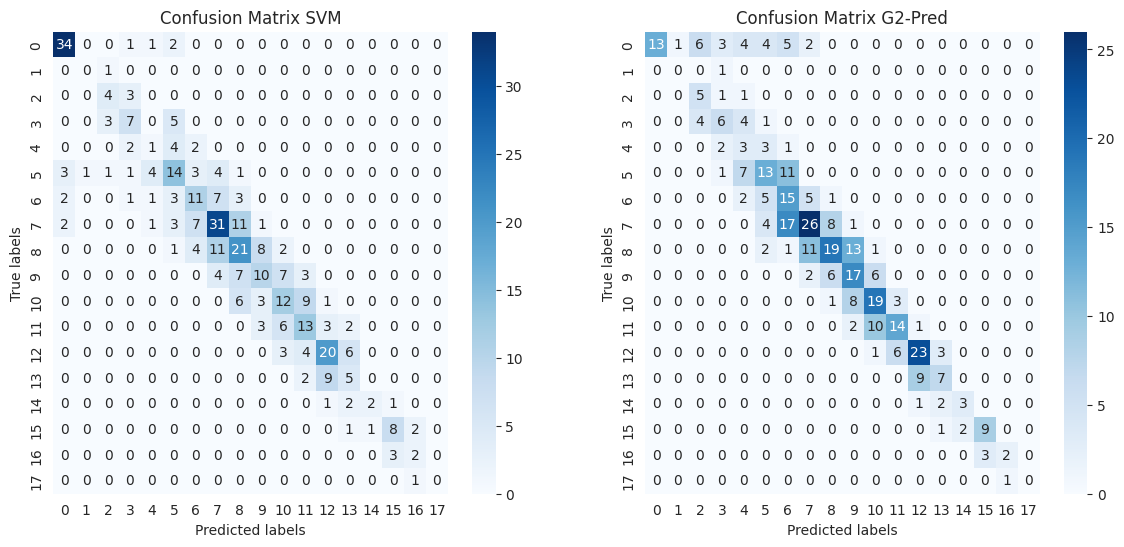

In [56]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

cmsvm = confusion_matrix(real_labels, svm_predictions)
sns.heatmap(cmsvm, annot=True, cmap=sns.color_palette("Blues", as_cmap=True), fmt="d", ax=ax1)
ax1.set_xlabel("Predicted labels")
ax1.set_ylabel("True labels")
ax1.set_title("Confusion Matrix SVM")

cmg2 = confusion_matrix(real_labels, g2_predictions)
sns.heatmap(cmg2, annot=True, cmap=sns.color_palette("Blues", as_cmap=True), fmt="d", ax=ax2)
ax2.set_xlabel("Predicted labels")
ax2.set_ylabel("True labels")
ax2.set_title("Confusion Matrix G2-Pred")

plt.subplots_adjust(wspace=0.2)
#plt.savefig("conf_matrix.png")
#files.download("conf_matrix.png") 
plt.show()